In [30]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd

%matplotlib inline

# Dataset # 
Variação da corrente gasta de uma antena de celular em função da potência do sinal. O objetivo será modelar uma função que aproxime os dados.


In [60]:
#Carrega o modelo
df = pd.read_csv("model.csv")

x_att = df[['x']]
y_att = df[['y']]

x = x_att.as_matrix()
y = y_att.as_matrix()

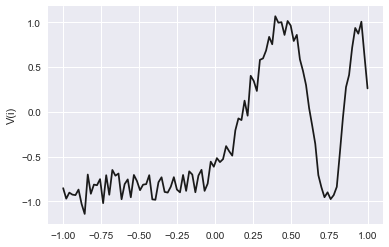

In [61]:
# plot dados originais.
plt.plot(x, y, 'k-')
plt.ylabel('i')
plt.ylabel('V(i)')
plt.show()

# Modelo RBF #

In [57]:
from scipy import *
from scipy.linalg import norm, pinv
 
from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8     #parâmetro épsilon.
        self.W = random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim #Testa o comprimento de d com indim.
        return exp(-self.beta * norm(c-d)**2) #Gaussiana
     
    def _calcAct(self, X):
        # Calcula a ativação das RBFs
        G = zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: Matrix de dimensões n x indim 
            y: vetor coluna de dimensão n x 1 """
        #Escolhe vetor centro aleatório do conjunto de teste 
        rnd_idx = random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
        #Debug
        #print("center", self.centers)
        #Calcula a ativação
        G = self._calcAct(X)
        #Calcula os pesos de saída.    
        self.W = dot(pinv(G), Y)
         
    def test(self, X):
        """ X: Matriz de dimensão n x indim """
        G = self._calcAct(X)
        Y = dot(G, self.W)
        return Y

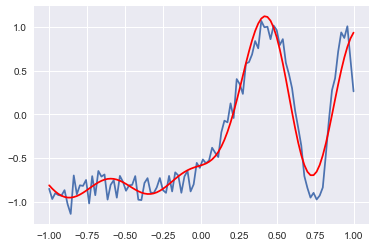

In [62]:
# rbf regression
rbf = RBF(1, 10, 1)
rbf.train(x, y)
z = rbf.test(x)

fig = plt.figure()
plt.plot(x, y, 'b-') 

#plot Observado
plt.plot(x, z, 'b-', color="red")

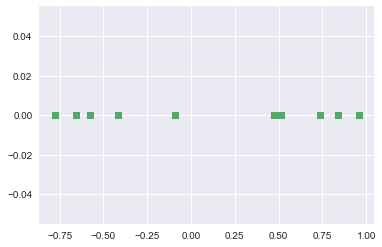

In [63]:
# plot rbfs
plt.plot(rbf.centers, zeros(rbf.numCenters), 'gs')
plt.show()

# Gaussian Processor#

** Predizer o preço de casas baseado em 79 variaveis**

Algumas variaveis:

* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.

* MSSubClass: The building class

* MSZoning: The general zoning classification

* LotFrontage: Linear feet of street connected to property

* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material

In [9]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import math
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, RBF, DotProduct, RationalQuadratic

#Funções de validação do dados.

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

def catcheck(df):
    iscat = np.zeros(df.shape[1])
    for c in range(df.shape[1]):
        if df.dtypes[c] == 'object':
            iscat[c] = 1
        else:
            iscat[c] = 0
    catdf = pd.DataFrame({'variable': df.columns, 'iscat': iscat})
    havecat = catdf[catdf.iscat == 1]
    catcolumn = havecat.variable.tolist()
    return catcolumn  

def NAcheck(df):
    isna = np.zeros(df.shape[1])
    for c in range(df.shape[1]):
        isna[c] = df.iloc[:, c].isnull().values.any()
    nandf = pd.DataFrame({'variable': df.columns, 'isna': isna})
    havenan = nandf[nandf.isna == 1]
    NAcolumn = havenan.variable.tolist()
    return NAcolumn

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Numero de registros para treinamento: %s" %len(train.index))
print("Numero de registros para test: %s" %len(test.index))

Numero de registros para treinamento: 1460
Numero de registros para test: 1459


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#Limpamos os dados
y_log = np.log1p(train["SalePrice"].values)     #normaliza os valores dos preços.
train1 = train.drop(["Id","SalePrice"], axis=1) #removo a variavel que queremos predizer
test1 = test.drop("Id", axis=1)                 #removo a variavel ID.

collist = set(NAcheck(train1) + NAcheck(test1)) #Checo variaveis com NA
train1 = train1.drop(collist, axis = 1)         #Removo as variaveis NA
test1 = test1.drop(collist, axis = 1)           #Removo as variaveis NA

#Outras validações
train1 = train1.drop(catcheck(train1), axis = 1)   
test1 = test1.drop(catcheck(test1), axis = 1)

print("Variaveis usadas no treino: %s" %train1.columns)

X = train1.values
X_test = test1.values

Variaveis usadas no treino: Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')


In [5]:
#Criamos Kernel do tipo Matern
kernel = 1.0**2 * Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=0.5)
#kernel = 1.0 * RBF(length_scale=1.0)
#Tentamos usar GaussianProcessRegressor
gp = GaussianProcessRegressor(kernel=kernel, alpha=5e-9, optimizer='fmin_l_bfgs_b', normalize_y=False)

In [6]:
clf = Pipeline([('scaler', StandardScaler()), ('gp', gp)])     
y_log_centered = y_log - y_log.mean()
y_pred = cross_val_predict(clf, X, y_log_centered, cv=5, n_jobs=-1) #aplica cross-validation
y = np.expm1(y_log)                                                  
y_pred = np.expm1(y_pred + y_log.mean())

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

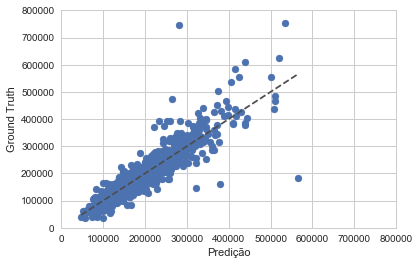

In [8]:
plt.scatter(y_pred, y)
plt.plot([min(y_pred),max(y_pred)], [min(y_pred),max(y_pred)], ls="--", c=".3")
plt.xlim([0,800000])
plt.ylim([0,800000])
plt.xlabel("Predição")
plt.ylabel("Ground Truth")
plt.show()